In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Objectives
1. Sales and Revenue Analysis (By customer, time, product)
2. Customer Behavior Analysis
3. RFM Analysis
4. Clustering

In [3]:
# Basic cleaning and revenue prep
df = df.dropna(subset=['CustomerID'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
# Overeall sales performance
total_revenue = df['Revenue'].sum()
total_orders = df['InvoiceNo'].nunique()
total_customers = df['CustomerID'].nunique()
aov = total_revenue / total_orders

total_revenue, total_orders, total_customers, aov

(8911407.904, 18532, 4338, 480.8659563997409)

In [5]:
# Revenue overtime
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

In [6]:
monthly_revenue = df.groupby('YearMonth')['Revenue'].sum().reset_index()
monthly_revenue['YearMonth'] = monthly_revenue['YearMonth'].astype(str)

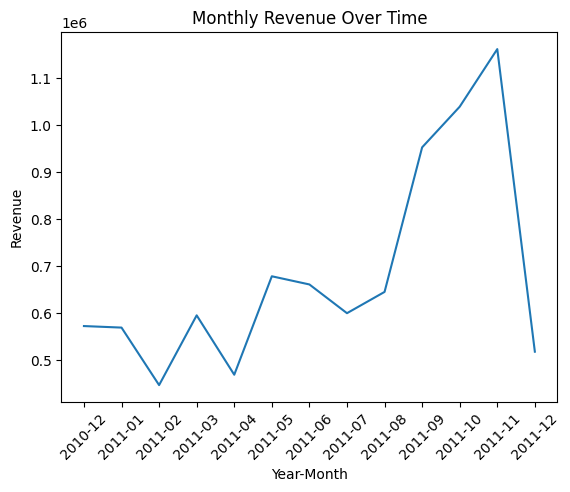

In [7]:
plt.figure()
plt.plot(monthly_revenue['YearMonth'], monthly_revenue['Revenue'])
plt.xticks(rotation=45)
plt.title('Monthly Revenue Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.show()

1. Chart shows growing trend
2. Seasonality spike at the end of the year

In [8]:
# Top products by revenue
top_products = df.groupby(['StockCode', 'Description'])['Revenue'].sum().sort_values(ascending=False).reset_index()
top_products.head(10)


,StockCode,Description,Revenue
0,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,22423,REGENCY CAKESTAND 3 TIER,142592.95
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,100448.15
3,85099B,JUMBO BAG RED RETROSPOT,85220.78
4,23166,MEDIUM CERAMIC TOP STORAGE JAR,81416.73
5,POST,POSTAGE,77803.96
6,47566,PARTY BUNTING,68844.33
7,84879,ASSORTED COLOUR BIRD ORNAMENT,56580.34
8,M,Manual,53779.93
9,23084,RABBIT NIGHT LIGHT,51346.20


1. Most revenue comes from e-commerce orders
2. Most of the items are party / festival related items

In [9]:
# Revenue per invoice
invoice_revenue = df.groupby('InvoiceNo')['Revenue'].sum().sort_values(ascending=False).reset_index()
invoice_revenue.head()


,InvoiceNo,Revenue
0,581483,168469.60
1,541431,77183.60
2,556444,38970.00
3,567423,31698.16
4,556917,22775.93


In [10]:
customer_metrics = (
    df.groupby('CustomerID')
    .agg(
        total_revenue=('Revenue', 'sum'),
        total_orders=('InvoiceNo', 'nunique'),
        total_quantity=('Quantity', 'sum'),
        first_purchase=('InvoiceDate', 'min'),
        last_purchase=('InvoiceDate', 'max')
    )
    .reset_index()
)

customer_metrics['avg_order_value'] = (
    customer_metrics['total_revenue'] / customer_metrics['total_orders']
)

customer_metrics['customer_lifetime_days'] = (
    customer_metrics['last_purchase'] - customer_metrics['first_purchase']
).dt.days

customer_metrics.head()


,CustomerID,total_revenue,total_orders,total_quantity,first_purchase,last_purchase,avg_order_value,customer_lifetime_days
0,12346.0,77183.60,1,74215,2011-01-18 10:01:00,2011-01-18 10:01:00,77183.600000,0
1,12347.0,4310.00,7,2458,2010-12-07 14:57:00,2011-12-07 15:52:00,615.714286,365
2,12348.0,1797.24,4,2341,2010-12-16 19:09:00,2011-09-25 13:13:00,449.310000,282
3,12349.0,1757.55,1,631,2011-11-21 09:51:00,2011-11-21 09:51:00,1757.550000,0
4,12350.0,334.40,1,197,2011-02-02 16:01:00,2011-02-02 16:01:00,334.400000,0


In [11]:
# Revenue concentration
customer_metrics = customer_metrics.sort_values(
    by='total_revenue', ascending=False
)

customer_metrics['revenue_share'] = (
    customer_metrics['total_revenue'] / customer_metrics['total_revenue'].sum()
)

customer_metrics['cumulative_revenue'] = (
    customer_metrics['revenue_share'].cumsum()
)
pareto_cutoff = (
    customer_metrics[customer_metrics['cumulative_revenue'] <= 0.8]
    .shape[0]
)

pareto_cutoff

1132

In [12]:
# RFM Analysis
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby('CustomerID')
    .agg(
        Recency=('InvoiceDate', lambda x: (analysis_date - x.max()).days),
        Frequency=('InvoiceNo', 'nunique'),
        Monetary=('Revenue', 'sum')
    )
    .reset_index()
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [13]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm[['R_score','F_score','M_score']] = rfm[['R_score','F_score','M_score']].astype(int)
rfm['RFM_score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [14]:
# RFM segmentation
def rfm_segment(row):
    if row['R_score'] >= 4 and row['F_score'] >= 4 and row['M_score'] >= 4:
        return 'Champions'
    elif row['R_score'] >= 3 and row['F_score'] >= 3:
        return 'Loyal Customers'
    elif row['R_score'] >= 4 and row['F_score'] <= 2:
        return 'New Customers'
    elif row['R_score'] <= 2 and row['F_score'] >= 3:
        return 'At Risk'
    elif row['R_score'] <= 2 and row['F_score'] <= 2:
        return 'Lost Customers'
    else:
        return 'Potential Loyalists'
rfm['Segment'] = rfm.apply(rfm_segment, axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,Lost Customers
1,12347.0,2,7,4310.00,5,5,5,555,Champions
2,12348.0,75,4,1797.24,2,4,4,244,At Risk
3,12349.0,19,1,1757.55,4,1,4,414,New Customers
4,12350.0,310,1,334.40,1,1,2,112,Lost Customers


In [15]:
segment_summary = (
    rfm.groupby('Segment')
    .agg(
        customers=('CustomerID', 'count'),
        revenue=('Monetary', 'sum'),
        avg_revenue=('Monetary', 'mean')
    )
    .sort_values(by='revenue', ascending=False)
)

segment_summary


,customers,revenue,avg_revenue
Segment,,,
Champions,962,5809341.070,6038.816081
Loyal Customers,998,1474127.551,1477.081714
At Risk,643,800531.551,1244.994636
Lost Customers,1065,519408.572,487.707579
Potential Loyalists,351,161832.590,461.061510
New Customers,319,146166.570,458.202414


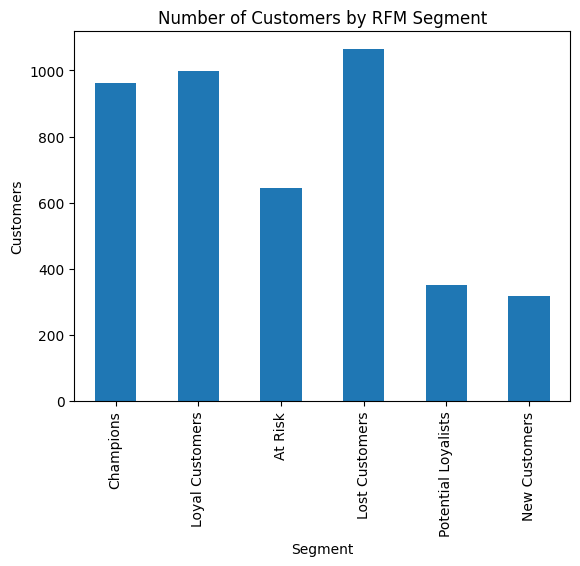

In [16]:
plt.figure()
segment_summary['customers'].plot(kind='bar')
plt.title('Number of Customers by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Customers')
plt.show()

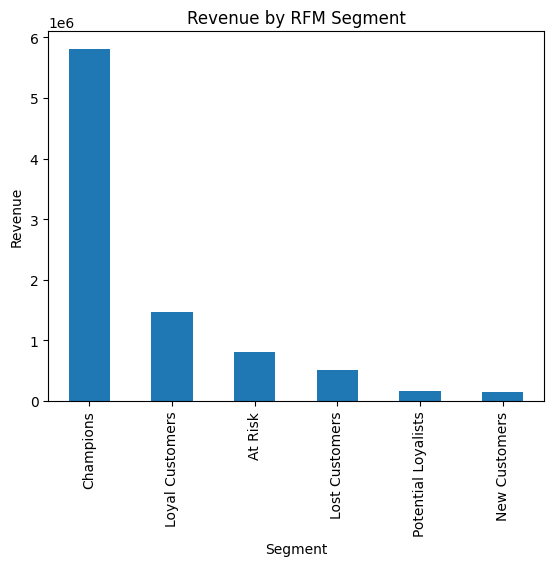

In [17]:
plt.figure()
segment_summary['revenue'].plot(kind='bar')
plt.title('Revenue by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Revenue')
plt.show()


RFM analysis reveals that 'Champions' contributes a disproportionate share of revenue. A sizable portion of customers fall into 'At risk'and 'Lost' segments, indicating churn potential. Targeted retention strategies for high value and at risk customers cna significantly improve revenue stability.

In [18]:
# RFM features for clustering
rfm_features = (
    rfm[['Recency', 'Frequency', 'Monetary']]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .copy()
 )
rfm_features['Frequency'] = np.log1p(rfm_features['Frequency'])
rfm_features['Monetary'] = np.log1p(rfm_features['Monetary'])

In [19]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

In [20]:
# Elbow method
inertia = []
K = range(2, 9)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

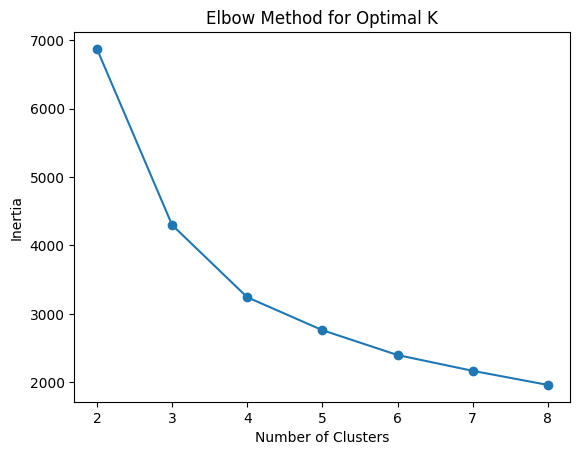

In [21]:
plt.figure()
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm.loc[rfm_features.index, 'Cluster'] = kmeans.fit_predict(rfm_scaled)

In [23]:
cluster_summary = (
    rfm.dropna(subset=['Cluster'])
    .groupby('Cluster')
    .agg(
        customers=('CustomerID', 'count'),
        avg_recency=('Recency', 'mean'),
        avg_frequency=('Frequency', 'mean'),
        avg_monetary=('Monetary', 'mean')
    )
    .sort_values(by='avg_monetary', ascending=False)
)
cluster_summary

,customers,avg_recency,avg_frequency,avg_monetary
Cluster,,,,
3.0,558,19.498208,16.034050,10007.540986
0.0,1447,45.418798,4.268141,1667.669657
1.0,1392,58.139368,1.519397,392.888779
2.0,941,259.183847,1.375133,390.202827


- Cluster 0: Regular customers
- Cluster 1: New Customers
- Cluster 2: Lost customers
- Cluster 3: Champions

In [24]:
cluster_labels = {
    0: 'Regular',
    1: 'New',
    2: 'Lost',
    3: 'Champions'
}

rfm['Cluster_Label'] = rfm['Cluster'].map(cluster_labels)


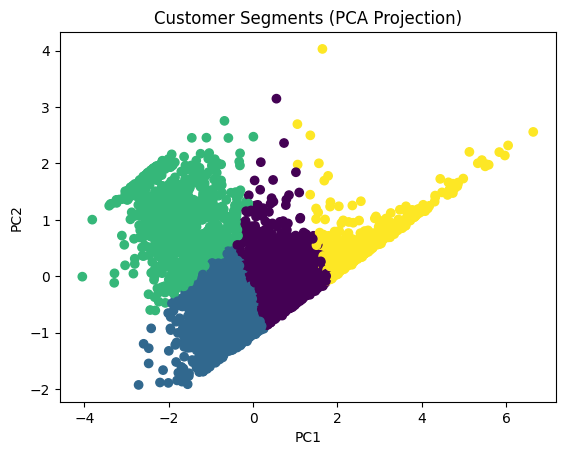

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure()
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm['Cluster'])
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [26]:
pd.crosstab(rfm['Segment'], rfm['Cluster_Label'])

Cluster_Label,Champions,Lost,New,Regular
Segment,,,,
At Risk,22,207,135,279
Champions,481,0,0,481
Lost Customers,0,734,302,29
Loyal Customers,55,0,338,605
New Customers,0,0,292,27
Potential Loyalists,0,0,325,26


1. Champion definition is robust
2. K-means is confident in identifying lost customers

In [27]:
# Save df and rfm to csv
df.to_csv("updated_retail.csv", index=False)
rfm.to_csv("rfm_segments.csv", index=False)